# Exploratory Data Analysis

## Imports

In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

import os
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as tfk

from sklearn import preprocessing
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from preprocessing.preprocessor import Preprocessor
from rnn.network import Network
from rnn.visualization import visualize_forecast

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tfk.callbacks.TensorBoard(logdir, histogram_freq=1)

## Load data

In [2]:
train: pd.DataFrame = pd.read_csv('data/no1_train.csv')
train.set_index('start_time', inplace=True)
test: pd.DataFrame = pd.read_csv('data/no1_validation.csv')
test.set_index('start_time', inplace=True)

y = train.pop('y')

# insert column with insert(location, column_name, column_value)

train.insert(0, 'y', y)


train.head()

,y,hydro,micro,thermal,wind,river,total,sys_reg,flow
start_time,,,,,,,,,
2019-01-09 14:10:00,341.330021,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:15:00,330.114330,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:20:00,323.877221,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:25:00,296.438463,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:30:00,269.097132,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4


In [3]:
train.describe()


,y,hydro,micro,thermal,wind,river,total,sys_reg,flow
count,225088.000000,225088.000000,225088.000000,225088.000000,225088.000000,225088.0,225088.000000,225088.000000,225088.000000
mean,8.907921,1888.334127,224.189826,21.803497,55.703266,0.0,2190.031963,-8.284305,-1999.055081
std,320.262539,401.000305,58.559855,3.579229,47.053033,0.0,444.077730,43.748315,1311.682286
min,-1579.680903,683.438000,80.371000,0.000000,0.000000,0.0,849.732000,-828.000000,-5541.200000
25%,-142.226700,1625.029000,185.017000,22.100000,15.704000,0.0,1916.523000,0.000000,-2996.700000
50%,-11.282351,1933.916000,225.938000,22.100000,41.848000,0.0,2248.874000,0.000000,-1953.700000
75%,127.454943,2175.595000,269.558000,24.100000,88.723000,0.0,2497.792000,0.000000,-906.900000
max,2956.333317,2995.524000,349.271000,25.700000,176.000000,0.0,3351.974000,474.000000,723.400000


## Data inspection

array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

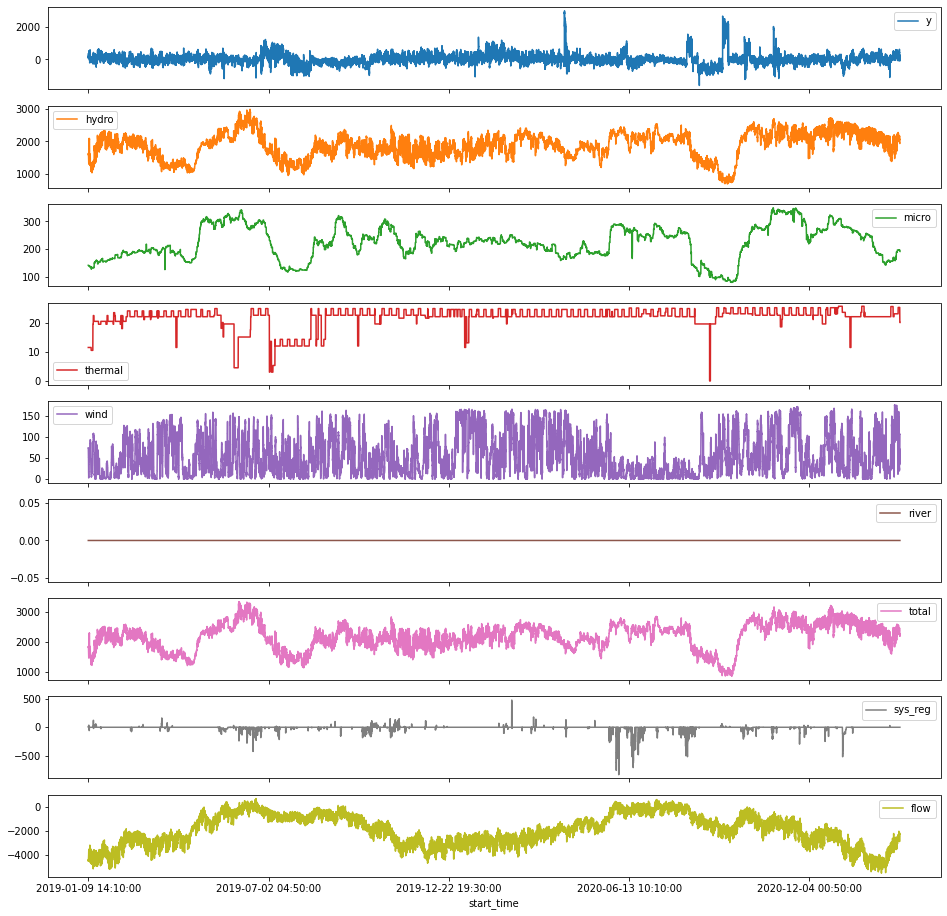

In [4]:
train.plot(subplots=True, figsize=(16,16))

## Preprocessing

array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

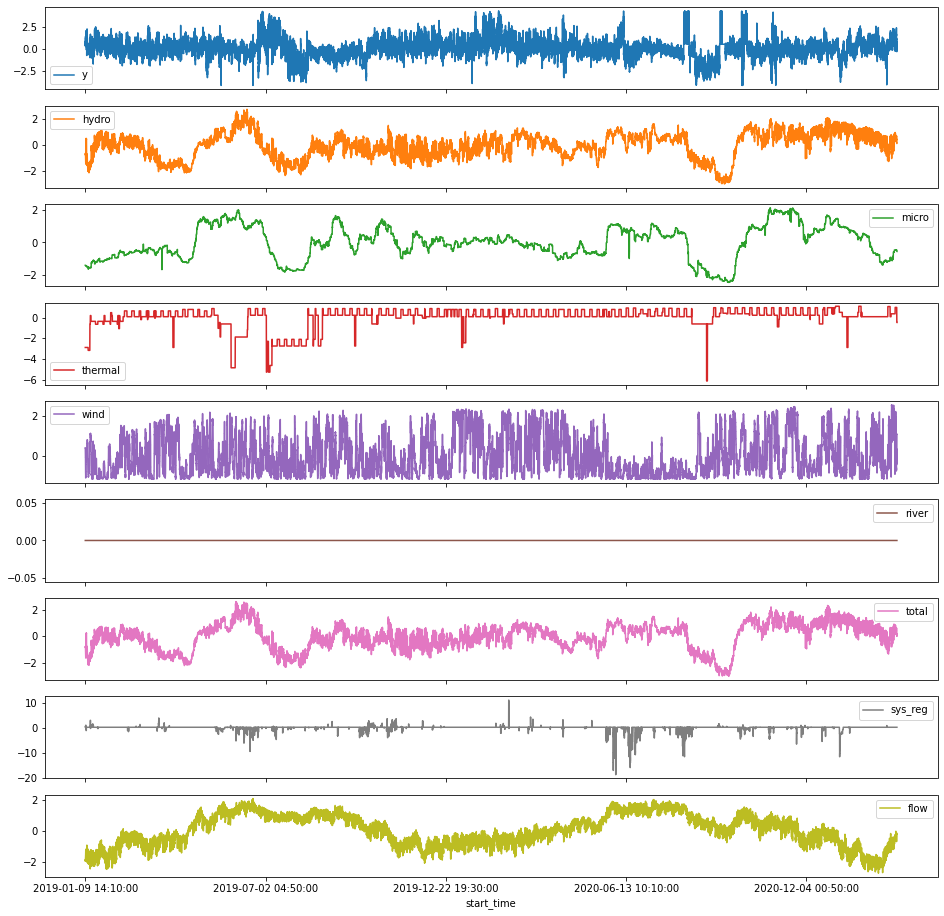

In [5]:
train_p = Preprocessor.pipeline(train, feature_engineering=False)
train_p.plot(subplots=True, figsize=(16,16))

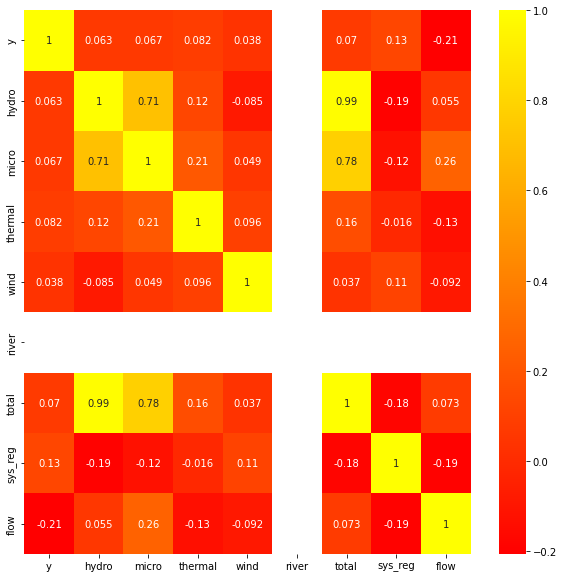

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(train_p.corr(), xticklabels=train_p.columns, yticklabels=train_p.columns, cmap='autumn', annot=True, ax=ax)
plt.show()

# Feature engineering

In [7]:
train_f = Preprocessor.pipeline(train_p, preprocessing=False)

In [8]:
train_f.head()

,y,hydro,micro,thermal,wind,river,total,sys_reg,flow,time_of_day_0,...,time_of_day_2,time_of_day_3,time_of_week,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,prev_y,prev_day_y,rolling_mean
start_time,,,,,,,,,,,,,,,,,,,,,
2019-01-10 14:10:00,1.433879,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.439464,1.307757,1.375215
2019-01-10 14:15:00,1.410102,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.433879,1.265605,1.402980
2019-01-10 14:20:00,1.396399,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.410102,1.242163,1.415471
2019-01-10 14:25:00,1.295119,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.396399,1.139039,1.399682
2019-01-10 14:30:00,1.250657,0.428928,-1.464007,-2.878698,0.159581,0.0,0.187968,0.189363,-1.70571,0,...,1,0,0,1,0,0,0,1.295119,1.036281,1.370937


In [9]:
print(train_f.index[0], train_f.index[24*12])

2019-01-10 14:10:00 2019-01-11 14:10:00


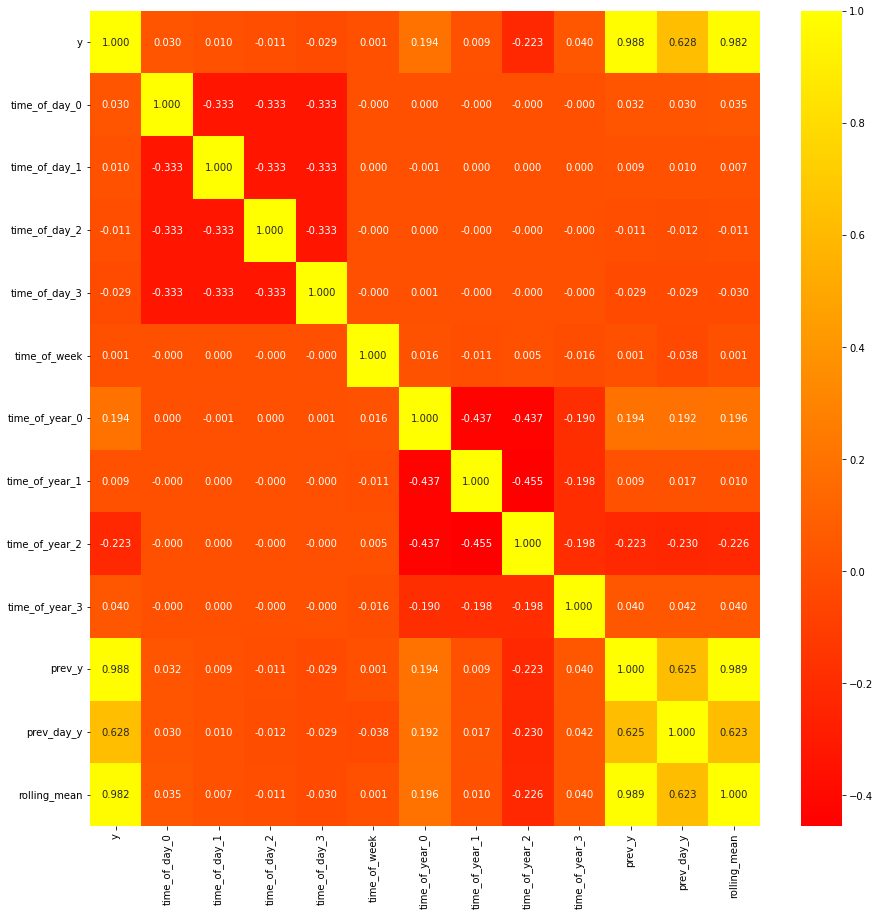

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
train_new = train_f.drop(columns=['hydro', 'micro', 'thermal', 'wind', 'river', 'total', 'sys_reg', 'flow'])
sns.heatmap(train_new.corr(), xticklabels=train_new.columns, yticklabels=train_new.columns, cmap='autumn', annot=True, ax=ax, fmt='.3f')
plt.show()

# Train RNN model

In [11]:
y = train_f['y']
x = train_f.drop(columns=['y', *[f'time_of_day_{i}' for i in range(4)], 'time_of_week', 'river'])
x.head()

,hydro,micro,thermal,wind,total,sys_reg,flow,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,prev_y,prev_day_y,rolling_mean
start_time,,,,,,,,,,,,,,
2019-01-10 14:10:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.439464,1.307757,1.375215
2019-01-10 14:15:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.433879,1.265605,1.402980
2019-01-10 14:20:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.410102,1.242163,1.415471
2019-01-10 14:25:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.396399,1.139039,1.399682
2019-01-10 14:30:00,0.428928,-1.464007,-2.878698,0.159581,0.187968,0.189363,-1.70571,1,0,0,0,1.295119,1.036281,1.370937


In [ ]:
sequence_length = 144
epochs = 10
learning_rate = 1e-3

input_shape = (sequence_length, x.shape[1])
net = Network(input_shape=input_shape, output_units=1, hidden_units=[128, 64], learning_rate=learning_rate)
net.fit(x, y, epochs=epochs, sequence_length=sequence_length, batch_size=64)

2022-04-14 10:07:53.319501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 10:07:53.329219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 10:07:53.329856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 10:07:53.330785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 128)          73216     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 122,689
Trainable params: 122,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-04-14 10:07:58.172313: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


2457/2457 [==============================] - 49s 18ms/step - loss: 0.1104 - mean_absolute_error: 0.2284 - val_loss: 0.1223 - val_mean_absolute_error: 0.2295
Epoch 2/10
2457/2457 [==============================] - 43s 18ms/step - loss: 0.0797 - mean_absolute_error: 0.1936 - val_loss: 0.0787 - val_mean_absolute_error: 0.1665
Epoch 3/10
2457/2457 [==============================] - 42s 17ms/step - loss: 0.0718 - mean_absolute_error: 0.1834 - val_loss: 0.0768 - val_mean_absolute_error: 0.1657
Epoch 4/10
2457/2457 [==============================] - 41s 17ms/step - loss: 0.0627 - mean_absolute_error: 0.1702 - val_loss: 0.1051 - val_mean_absolute_error: 0.1991
Epoch 5/10
2457/2457 [==============================] - 40s 16ms/step - loss: 0.0547 - mean_absolute_error: 0.1581 - val_loss: 0.0863 - val_mean_absolute_error: 0.1846
Epoch 6/10
2457/2457 [==============================] - 40s 16ms/step - loss: 0.0502 - mean_absolute_error: 0.1498 - val_loss: 0.0838 - val_mean_absolute_error: 0.1828
Epo

In [ ]:
test_f = Preprocessor.pipeline(test)
y_test = test_f['y']
x_test = test_f.drop(columns=['y', *[f'time_of_day_{i}' for i in range(4)], 'time_of_week', 'river'])

# Get missing columns in the training test
missing_cols = set(x.columns ) - set(x_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    x_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
x_test = x_test[x.columns]

x_test.head()

In [ ]:
forecast_start = np.random.randint(sequence_length, x_test.shape[0] - sequence_length)
forecast_steps = 24

y_hat = net.multistep_predict(x_test, forecast_start=forecast_start, forecast_steps=forecast_steps)
visualize_forecast(y_test.to_numpy(), y_hat, history_length=forecast_steps*2, forecast_start=forecast_start)

In [ ]:
%tensorboard --logdir logs